# DQN
Trying to get DQN to work for MountainCar. Recall that Q learning is an off-policy learning scheme, meaning the TD update (and hence the TD error) is computing by maximizing over the action space. That is, we find:

$$ TD = Q(S, A) - (R + \gamma \max_A Q(S', A)) $$

Where an on-policy would simply have $Q(S', A')$ in place of $\max_A Q(S', A)$. The two main implementation details that seem to be necessary to get DQNs working are:
- Replay buffer: Collect samples in a buffer that gets sampled uniformly at random for training batches. This reduces sample correlation and, therefore, increases training convergence
- Separate policy and training networks: The policy network is used to generate samples, which are then used to train the training network. The policy network is updated to the training network after several training steps, which stabilizes the training process

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = gym.make("MountainCar-v0")

In [3]:
class DQN(nn.Module):
    def __init__(self, S, A):
        super(DQN, self).__init__()
        
        self.S = S
        self.A = A
        H = 64
        
        self.d1 = nn.Linear(S, H)
        self.d2 = nn.Linear(H, H)
        self.d3 = nn.Linear(H, A)
        
    def forward(self, x):
        output = self.d1(x)
        output = F.relu(output)
        output = self.d2(output)
        output = F.relu(output)
        output = self.d3(output)
        return output

In [5]:
episodes = 200
epsilon = 0.5
gamma = 1.0

batch_size = 100
 
S = env.observation_space.shape[0]
A = env.action_space.n

policy_net = DQN(S, A)
training_net = DQN(S, A)

loss_criterion = nn.HuberLoss()
optimizer = optim.Adam(training_net.parameters())

replay_buffer = []

losses = []

for episode in range(episodes):
    if episode > 0 and episode % 100 == 0:
        policy_net = copy.deepcopy(training_net)
        epsilon /= 2
    
    done = False
    
    state = env.reset()
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action_probs = policy_net(torch.tensor(state))
            action = torch.argmax(action_probs).detach().numpy()
            
        new_state, reward, done, _ = env.step(action)
        td_target = reward + gamma * torch.max(policy_net(torch.tensor(new_state)))
        
        train_sample = (np.array(state), action, td_target.detach().numpy())
        replay_buffer.append(train_sample)
        
        state = new_state
    
    batch = [random.choice(replay_buffer) for _ in range(batch_size)]
    batch_states, batch_actions, batch_targets = list(zip(*batch))
    
    batch_states = torch.tensor(np.array(batch_states))
    batch_actions = torch.tensor(np.array(batch_actions))
    batch_targets = torch.tensor(np.array(batch_targets))
    
    predicted_qs = training_net(batch_states)
    predicted_targets = torch.index_select(predicted_qs, 1, batch_actions)
    
    loss = loss_criterion(predicted_targets, batch_targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach().numpy())
    
    if episode % 10 == 0:
        print(f"Epoch : {episode} / {episodes} -- Loss : {loss}")

Epoch : 0 / 200 -- Loss : 0.42277586460113525
Epoch : 10 / 200 -- Loss : 0.266987681388855
Epoch : 20 / 200 -- Loss : 0.12340264022350311
Epoch : 30 / 200 -- Loss : 0.04561480134725571
Epoch : 40 / 200 -- Loss : 0.011521858163177967
Epoch : 50 / 200 -- Loss : 0.00410460913553834
Epoch : 60 / 200 -- Loss : 0.00034728756872937083
Epoch : 70 / 200 -- Loss : 0.0007404980133287609
Epoch : 80 / 200 -- Loss : 0.0002512590726837516
Epoch : 90 / 200 -- Loss : 0.00016991271695587784
Epoch : 100 / 200 -- Loss : 9.986878285417333e-05
Epoch : 110 / 200 -- Loss : 0.04239533841609955
Epoch : 120 / 200 -- Loss : 0.04516718164086342
Epoch : 130 / 200 -- Loss : 0.05282340198755264
Epoch : 140 / 200 -- Loss : 0.05820326507091522
Epoch : 150 / 200 -- Loss : 0.08187833428382874
Epoch : 160 / 200 -- Loss : 0.08614504337310791
Epoch : 170 / 200 -- Loss : 0.04846261069178581
Epoch : 180 / 200 -- Loss : 0.06227394938468933
Epoch : 190 / 200 -- Loss : 0.07530735433101654


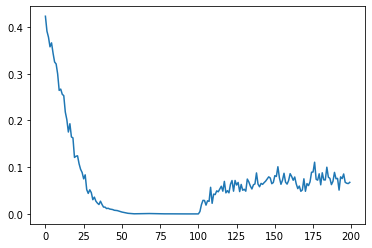

In [6]:
plt.plot(range(len(losses)), losses)
plt.show()

In [7]:
state = env.reset()
done = False
while not done:
    env.render(mode='rgb_array')
    action_probs = policy_net(torch.tensor(state))
    action = torch.argmax(action_probs).detach().numpy()
    state, _, done, _ = env.step(action)